In [1]:
# import confusionTable_extractFeature as CTF

In [2]:
import math

In [3]:
import sys
import os
import argparse

In [4]:
from multiprocessing import Pool

In [5]:
import pickle
import numpy as np
from sklearn import svm

In [6]:
from sklearn.preprocessing import Normalizer, StandardScaler

In [7]:
from sklearn.naive_bayes import GaussianNB

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [9]:
with open('./ch_5401.txt', 'r', encoding='utf8') as fp:                    
    CH5400 = set(i.strip() for i in fp.readlines())

In [10]:
POS = 1
NEG = -1
UNK = 2

In [11]:
PROCESSCNT = 6
MULTIPROCESS = True
PRE = False
NB = False

In [12]:
def fCombine(score, log):
    '''The method of extract feature 
    Args:
        score(float): total score of feature 
        log(list): feature 
    Return:
        tmp(list): selected feature 
    '''
    # 0.89/0.86    
#     tmp = log[:-2]
#     tmp.append(score-log[-3]*9-log[-2])
    
    
    # 0.90/0.89
#     tmp = log[:-2]

    # 0.90/0.89
#     tmp = log[:-2]

    # 0.99/0.99
#     tmp = log[:-2]
#     tmp.append(score)

    # 0.89/0.86
#     tmp = log[:-2]
#     s = sum(log[:-2])
#     tmp.append(s)

    # 0.99/0.99
    tmp = log[:-2]
    s = score - log[-3]*9
    tmp.append(s)
    
    
    return tmp

In [13]:
def extract(dataset):
    '''Extract (feature/label) from filename
    Args:
        bigDict (nested dict): the dict of feature (*.pkl) from confusionTable_extractFeature
    Return:
        train_feature (np.array): feature array
        train_label (np.array): the label of feature             
    '''    
    
    # Initial 
    label = list()
    feature = list()

    for error_ch, (cands_val) in dataset.items():           
        if error_ch not in CH5400:
            # If confusion matrix have, choose 
            # else choose the highest score            
            in_pairs = {cand:(score, log) for cand, (score, log) in cands_val.items() if log[-2]!=0}
            if not in_pairs:
                try:
                    best_cand = max(cands_val.items(), key=lambda x:x[1][0])                
                except:
                    print(cands_val)
                    return 
                dataset[error_ch] = {best_cand[0]:best_cand[1]}
            else:
                dataset[error_ch] = in_pairs
            continue        
        
        # two situation for error: (error-pair) or (higher-score)
        # Skip the candidates which is not in COMMON-5000
        for cand, (score, log) in cands_val.items():  
            if cand not in CH5400:
                continue
                                    
            feature.append(fCombine(score,log))
            if log[-2] != 0:
                label.append(POS)
            else:
                label.append(UNK)
    
    # Combine
    train_feature = np.asarray(feature, dtype='float')            
    tmp_label = np.asarray(label, dtype='int')
    pos = np.where(tmp_label == POS )[0]
    neg = np.where(tmp_label == UNK )[0]
    train_label = {POS:pos, UNK:neg}        

    print('The number of sample = {}'.format(train_feature.shape))
    print('Positive case (candidate) = {}'.format(len(train_label[POS])))
    print('Negative case (uncandidate) = {}'.format(len(train_label[UNK])))
    
    return (train_feature, train_label)

In [14]:
def preprocess(data, method):
    '''Preprocessing of feature    
    Args:
        data (np.array): feature 
        method (str): 'normal'-normalization // 'standard'-standardization
        (Normal is better)
    Return:
        new_data (np.array): after preprocessing 
        pre (scikit.preprocess): transform model for feature     
    '''
    if PRE:    
        if method == 'normal':
            pre = Normalizer().fit(data)
            new_data = pre.transform(data)
        elif method == 'standard':
            pre = Normalizer().fit(data)
            new_data = pre.transform(data)
        else:
            print('Unknown method')
            sys.exit(0)
        
        return (new_data, pre)
    else:
        return (data, [])

In [15]:
def rnBatch(para):
    (idx, feature, nbf) = para
    
    if nbf.predict(feature.reshape(1,-1)) == UNK:
        return idx
    else:
        return -1

In [16]:
def rnSelect(feature, label):
    
    if NB:
        
        nbf_idx = np.concatenate((label[POS],label[UNK]))
        nbf_label = np.concatenate(
            (np.full(len(label[POS]), POS, dtype=int)
             , np.full(len(label[UNK]), UNK, dtype=int)))
        nbf_feature = feature[nbf_idx]
        nbf = GaussianNB().fit(nbf_feature, nbf_label)

        print('Prepare chunk')
        chunk = [(idx, feature[idx], nbf) for idx in label[UNK]]

        print('Start RN step select')    
        if MULTIPROCESS:
            with Pool(processes=PROCESSCNT) as pool:
                rn_neg = pool.map(rnBatch, chunk)
        else:
            rn_neg = [rnBatch(c) for c in chunk]


        label[NEG] = np.where(np.asarray(rn_neg) != -1)[0]


        print('Label[POS]: {}'.format(len(label[POS])))
        print('Label[NEG]: {}'.format(len(label[NEG])))
        print('Remove Unknown {} samples'.format(len(label[UNK])-len(label[NEG])))
    
    else:
        label[NEG] = label[UNK]
    
    return label

In [17]:
def train_svm(feature, label, train_cnt, cost= 0, g=1/11, test_cnt=0, cross_validation=False):
    '''Train SVM model from feature
    Args:
        feature (np.array): feature array
        label (np.array): the label of feature 
        train_cnt (int): the number of training samples 
        test_cnt (int): (default=samples-train_cnt) the number of testing samples
    Return:
        xxx    
    '''
    
    assert train_cnt < len(label[POS]), 'Train count must less than positive samples'
    
    # If test_cnt not declare, use all the remain set as test set    
    if train_cnt==0:
        assert False, 'sample count cannot be zero'
        
    if test_cnt==0:
        test_cnt = len(label[POS]) - train_cnt
        
    # Picke feature/label to train & test set    
    np.random.shuffle(label[POS])
    np.random.shuffle(label[NEG])

    train_idx = np.concatenate(
        (label[POS][:train_cnt],
         label[NEG][:train_cnt]))
    train_label = np.concatenate(
        (np.full(train_cnt, POS, dtype=int), np.full(train_cnt, NEG, dtype=int)))
    train_feature = feature[train_idx]

    test_idx = np.concatenate(
        (label[POS][train_cnt:train_cnt+test_cnt], 
         label[NEG][train_cnt:train_cnt+test_cnt]))
    test_label = np.concatenate(
        (np.full(test_cnt, POS, dtype=int), np.full(test_cnt, NEG, dtype=int)))
    test_feature = feature[test_idx]

    # Training 
    clf = svm.SVC(kernel='rbf',C=cost,gamma=g, probability=True)
    clf.fit(train_feature,train_label)
    
    # Testing 
    accuracy = clf.score(test_feature, test_label)
    pos_acc = clf.score(test_feature[:test_cnt], test_label[:test_cnt])
    print('Accuracy ({}/{}): {}'.format(test_cnt, len(test_label), accuracy))
    print('Positive Accuracy ({}): {}'.format(test_cnt, pos_acc))
    
#     output = [accuracy, train_cnt, test_cnt*2]
#     return output
    return clf, accuracy

In [18]:
def create_batch(chunk):
    global clf
    global pre_filter
    global threshold
    
    (ch, cands) = chunk  
    
    f_batch = []
    for ca, (score,log) in cands.items(): 
        if ca not in CH5400:
            continue        
        
        if False:
#         if log[-2] != 0:
            f_batch.append((ca, 1))   
        else:
            cand_feature = fCombine(score,log)
            if PRE:                
                tmp = pre_filter.transform(np.asarray(cand_feature).reshape(1,-1))
            else:
                tmp = np.asarray(cand_feature).reshape(1,-1)
            
            f = clf.predict_proba(tmp).tolist()[0]            
                               
            if f[1] > f[0] and f[1] > threshold[0]:
                f_batch.append((ca, f[1]))
#             elif log[-2] != 0:
#                 print(ch, ca)

    if len(f_batch) > 0:
        f_sorted = sorted(f_batch, key=lambda x:x[1], reverse=True)[:threshold[1]]
        f_dict = {ca:s for ca, s in f_sorted}

        return (ch, f_dict)
    else:
        return []


In [19]:
def create(bigDict):    
    '''Select the candidates in bigDict
    
    '''    
    confusion = dict()
    c_t, c_tf, sk = 0,0,0
    
    tt = list(bigDict.items())
    
    if MULTIPROCESS:
        with Pool(processes=PROCESSCNT) as pool:
            r = pool.map(create_batch, tt)
        confusion = {c[0]:c[1] for c in r if len(c)>0}
    else:
        for chunk in tt:
            batch = create_batch(chunk)
            if len(batch)>0:
                confusion[batch[0]] = batch[1] 
            
    return confusion

In [20]:
def info(confusion, fig_token):
    '''Get basic information about NCM 
    
    '''
    total_error = len(confusion)
    cands = [(ch, len(cand)) for (ch, cand) in 
        sorted(confusion.items(), key= lambda x:len(x[1]), reverse=True)]

    sum_cands = sum(cnt for _, cnt in cands)
    max_cands = max(cnt for _, cnt in cands)
    min_cands = min(cnt for _, cnt in cands)
    mean_cands = sum_cands/total_error
    
    if total_error%2 == 0:
        mid_cands = cands[total_error//2]
    else:
        mid_cands = cands[(total_error+1)//2]
    
    print('Total_error: {}\nSum_cands: {}'.format(total_error, sum_cands))
    print('Max_cands: {}\nMin_cands: {}'.format(max_cands, min_cands))
    print('Mean_cands: {:.2f}\nMid_cands: {}'.format(mean_cands, mid_cands))
    print('Top 20 cands:\n {}'.format(cands[:20]))
    
    plt.plot([cnt for _, cnt in cands])
    plt.xlabel('index')
    plt.ylabel('candidates number')
    fig = plt.gcf()
#     plt.show()
    fig.savefig('./confusionTable/confuInfo_{}.png'.format(fig_token), dpi=100)

In [21]:
def outputPKL(confusion, ncm_correct, pkl_file):
    '''Assign local probability and output to NCM file
    '''
    output = defaultdict(dict)
    print('Output PKL')
    for ch, cands in confusion.items():
        total_cand_val = sum(cands.values())*(1-ncm_correct) + ncm_correct
        output[ch] = {ca:(p*(1-ncm_correct))/total_cand_val for ca,p in cands.items()}
        output[ch][ch] = ncm_correct/total_cand_val        
    
    with open(pkl_file, 'wb') as fp:
        pickle.dump(output, fp)
    
    return output

In [22]:
def process_command():
    parser = argparse.ArgumentParser()
    parser.add_argument('--token', required=True)
    parser.add_argument('--multi', action='store_false')
    parser.add_argument('--pre', action='store_true')
    parser.add_argument('--nb', action='store_true')    
    
    return parser.parse_args()

In [23]:
# args = process_command()
feature_file = './confusionTable/feature.pkl'
output_file = './confusionTable/confu_{}_{}_{}.pkl'.format

with open(feature_file, 'rb') as fp:
    dataset = pickle.load(fp)        

In [27]:
'勣' in CH5400

True

In [24]:
print('Before extract = {}'.format(sum(len(cand) for cand in dataset.values())))

Before extract = 2592820


In [25]:
feature,label = extract(dataset)
print('After extract = {}'.format(sum(len(cand) for cand in dataset.values())))

The number of sample = (1561823, 11)
Positive case (candidate) = 8400
Negative case (uncandidate) = 1553423
After extract = 1717879


PRE	False
NB	False
trainSet = 4000	cost_pars = 1	gamma = 0.09
Accuracy (4400/8800): 0.9931818181818182
Positive Accuracy (4400): 0.9986363636363637
Total_error: 5152
Sum_cands: 19638
Max_cands: 26
Min_cands: 1
Mean_cands: 3.81
Mid_cands: ('靦', 3)
Top 20 cands:
 [('是', 26), ('事', 22), ('經', 19), ('以', 18), ('理', 18), ('付', 18), ('古', 18), ('至', 18), ('維', 17), ('模', 17), ('奇', 17), ('期', 17), ('時', 17), ('住', 17), ('莫', 16), ('裡', 16), ('愈', 16), ('適', 16), ('愉', 16), ('其', 16)]


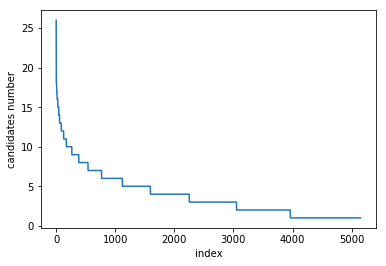

In [26]:
PROCESSCNT = 8
TOKEN = args.token
MULTIPROCESS = args.multi
PRE = args.pre
NB = args.nb

# TOKEN = 'd'
# MULTIPROCESS = True
# PRE = False
# NB = False

print('PRE\t{}NB\t{}'.format(PRE,NB))

# train_cnt_pars = list(range(1000, 5000, 1000))
# cost_pars = [0.125, 0.25, 0.5, 1, 2, 4, 8]
# gamma_pars = [0.0225, 0.045, 0.09, 0.18, 0.36]
# threshold = [0.9,50]
# ncm_setting_pars = [0.9995, 0.99995, 0.999995, 0.9999995]

train_cnt_pars = [4000]
cost_pars = [1]
gamma_pars = [0.09]
threshold = [0, 30]
ncm_setting_pars = [0.9995]


for train_cnt in train_cnt_pars:
    for cost in cost_pars:
        for gamma in gamma_pars:
            print('trainSet = {}\tcost_pars = {}\tgamma = {}'.format(train_cnt, cost, gamma))            
            batch_token = '{}_{}_{}_{}'.format(TOKEN, str(train_cnt), str(cost)[2:], str(gamma)[2:])
            (new_feature, pre_filter) = preprocess(feature, 'normal')
            label = rnSelect(new_feature, label)            
            clf, accuracy = train_svm(new_feature, label, train_cnt, cost, gamma)

            confu_raw = create(dataset)
            info(confu_raw, batch_token)
            for ncm_setting in ncm_setting_pars:
                confu = outputPKL(confu_raw, ncm_setting, output_file(TOKEN, batch_token, str(ncm_setting)[2:]))